### Overview

This notebook uses **binary matrix factorization (BMF)** to identify latent recipes in the dataset.

The analyses are based on a binary matrix (X), with rows representing the recipes (size $n$), columns representing all the ingredients (size $p$); each entry is a boolean value indicating whether the corresponding ingredient is in that certain recipe. Note that we do not have access to cuisine labels in these analyses (thus unsupervised).

#### A brief intro to BMF

BMF is a special case of non-negative matrix factorization (a type of unsupervised learning methods). It tries to factorize binary matrix X into two matrices H and W :
$$
X \approx HW,
$$

where $X \in \mathbb{R}^{n \times p}$, $H \in \mathbb{R}^{n \times r}$ and $W \in \mathbb{R}^{r \times p}$.

In the case of this dataset, this can be seen as finding $r$ latent recipes, with basis matrix $W$ describing their tendency to have each ingredient, and mixture matrix $H$ quantifying how each recipe can be seen as a weighted combination of the latent recipes.

A more detailed description of BMF (and its comparison with other unsupervised learning methods) can be found in [Zhang et al. (2007)](https://ieeexplore.ieee.org/abstract/document/4470263).

#### Prerequisite

We use python package [Nimfa](http://nimfa.biolab.si/) to implement the BMF method. To run this notebook, you need to first install Nimfa via `pip install nimfa`.

#### Relationship with other jupyter notebooks and other files in the repository

Later when examining the analysis results, it will be helpful to have the notebook `DataExploration.ipynb` (specifically the secion "The most common ingredients in each cuisine") open to compare the ingredients in latent recipes to the common ingredients in each cuisine .

Folder `BMFresults/` have all the results of running the BMF models with different numbers of latent recipes (only the W matrices for now; will add the H matrices if we end up analyzing them). Fitting all these models will take forever locally... I ran them on the cluster and saved the results, so we can just load in the results.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nimfa
from collections import Counter

### Load the data

In [22]:
data = pd.read_json('train.json')
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


### Create a binary matrix indicating whether or not an ingredient is in a recipe

In [23]:
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)
dataBinaryIngredients.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Binary matrix facterization (using package nimfa)

#### Try 6 latent components ("latent" recipes)

In [4]:
%%time

NComponents = 6
X = dataBinaryIngredients.values

# use default values for lambda_w and lambda_h, increase max_iter to 100 to make sure fitting converges
bmf = nimfa.Bmf(X, seed="nndsvd", rank=NComponents, max_iter=100, lambda_w=1.1, lambda_h=1.1)
bmf_fit = bmf()

/Users/mingyusong/anaconda3/envs/cos424/lib/python3.7/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/Users/mingyusong/anaconda3/envs/cos424/lib/python3.7/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


CPU times: user 16min 1s, sys: 2min 41s, total: 18min 42s
Wall time: 10min 38s


In [6]:
# get the two matrices
W = np.array(bmf_fit.coef())
H = np.array(bmf_fit.basis())

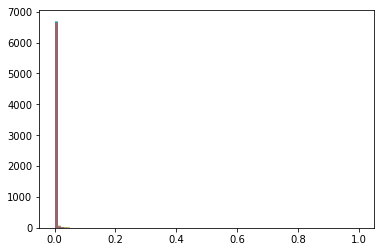

In [19]:
# most feature weights are very close to 0, i.e. weight matrix W is very sparse
for i in range(NComponents):
    sns.distplot(W[i,:], bins=np.linspace(0,1,101), label=i, kde=False)

In [9]:
# top (0.1%) ingredients for each "latent recipe"
print('Top ingredients for each "latent recipe":')
Ntop = 10
for i in range(NComponents):
    topIndices = np.where(W[i,:] > np.percentile(W[i,:], 99.9))[0]
    topIndices = topIndices[np.argsort(-W[i, topIndices])]
    # print the ingredients and their weights
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices])

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter' 'butter'
 'baking powder' 'milk'] [0.80031423 0.77347722 0.42743228 0.37916551 0.37514472 0.33897218
 0.25870744]
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots'
 'vegetable oil'] [0.97898678 0.6086343  0.18198474 0.17025485 0.14434273 0.13881632
 0.12238046]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'extra-virgin olive oil' 'grated parmesan cheese' 'purple onion'] [0.93341646 0.59477419 0.32937025 0.13827699 0.13744918 0.12089553
 0.11997928]
Latent recipe 4 : ['salt' 'pepper' 'butter' 'eggs' 'black pepper' 'oil' 'flour'] [1.05014124 0.2701847  0.11458608 0.08254085 0.06046895 0.05168506
 0.05016358]
Latent recipe 5 : ['water' 'garlic cloves' 'carrots' 'salt' 'vegetable oil' 'oil'
 'chopped onion'] [1.00357722 0.05137566 0.03993033 0.0377805  0.03681479 0.03420766
 0.02965419]
Latent re


**Some observations from NComponents = 6:**
- It picks out the some cuisines!! Just eyeballing the top ingredients, there seems to be the following mappings: latent recipe 1: southern-us; 2: mexican; 3: italian; 6: chinese. Interestingly (and also probably as expected?), these cuisines are the ones with the most recipes.
- Other latent recipes (4 and 5) don't seem to map to any specific cuisine, but are a collection of commonly used ingredients. Note that latent recipe 5 might seem an odd combination of ingredients, but if we look at the weights, it's only 'water' that has a very high weight, so we can probably think of this latent recipe just representing the common ingredient 'water'.

#### What about other values of NComponents?

(The complete results of NComponents = 2 to 20 can be found <a href='#moreNComponent'>here</a>.)

1. In general, if `NComponents` is too small, the latent recipes just pick out some common ingredients, which isn't super interesting.

Here is an example of NComponents = 2:

In [17]:
NComponents = 2

# load in BMF results
W = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_W.csv', header=None, index_col=False).values

# top ingredients for each "latent recipe" and their weights
print('Top ingredients for each "latent recipe":')
for i in range(NComponents):
    topIndices = np.where(W[i,:] > np.percentile(W[i,:], 99.9))[0]
    topIndices = topIndices[np.argsort(-W[i, topIndices])]
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices])

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'sugar' 'all-purpose flour' 'butter' 'large eggs' 'eggs'
 'unsalted butter'] [0.80848312 0.71335787 0.66128501 0.45523304 0.35484499 0.30094422
 0.30065275]
Latent recipe 2 : ['salt' 'onions' 'olive oil' 'garlic' 'garlic cloves' 'water' 'pepper'] [0.73250573 0.49962053 0.45732962 0.4340472  0.32212044 0.30930382
 0.26627989]


2. With larger `NComponents` values, the model doesn't continue to pick out more cuisines as we increase `NComponents`; still only the major cuisines get picked out (e.g. italian, southern-us, mexican and chinese). The other latent recipes are usually very sparse with only one or a couple ingredient having weights close to 1, and others having very small weights; these 'stand-out' ingredients are usually the common ingredients.

Here is an example of NComponents = 15 (top 0.1% ingredients are shown, with an additional cutoff criterion of weight>0.1 to make the results more clear):

In [18]:
NComponents = 15

# load in BMF results
W = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_W.csv', header=None, index_col=False).values

# top ingredients for each "latent recipe" and their weights
print('Top ingredients for each "latent recipe":')
for i in range(NComponents):
    topIndices = np.where((W[i,:] > np.percentile(W[i,:], 99.9))&(W[i,:] > 0.1))[0]
    topIndices = topIndices[np.argsort(-W[i, topIndices])]
    print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices])

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar'] [1.0001615]
Latent recipe 2 : ['garlic' 'onions'] [1.04728348 0.43421348]
Latent recipe 3 : ['olive oil'] [1.00010914]
Latent recipe 4 : ['butter' 'milk'] [1.00917809 0.13550916]
Latent recipe 5 : ['water'] [0.99720205]
Latent recipe 6 : ['soy sauce' 'sesame oil' 'green onions' 'corn starch' 'scallions'
 'rice vinegar' 'ginger'] [0.98835219 0.55217838 0.48252297 0.30626869 0.30043369 0.29290696
 0.24322356]
Latent recipe 7 : ['vegetable oil'] [1.00002379]
Latent recipe 8 : ['garlic cloves' 'onions'] [1.006723   0.25183557]
Latent recipe 9 : ['ground cumin' 'chili powder' 'tomatoes' 'jalapeno chilies'
 'chopped cilantro fresh' 'sour cream' 'avocado'] [0.7469894  0.51436138 0.32002288 0.29969831 0.27608738 0.26425783
 0.25773901]
Latent recipe 10 : ['salt'] [0.91667854]
Latent recipe 11 : ['pepper'] [0.99974241]
Latent recipe 12 : ['onions' 'eggs' 'oil' 'milk' 'salt' 'flour'] [0.41685365 0.39307138 0.19238655 0.1233020


**Summary for NComponents = 15:**
- Most latent recipes are very sparse (with only one ingredient having feature weight > 0.1)
- (Following the first point) common ingredients are picked out by these sparse latent recipes: e.g. sugar, salt, pepper, water, etc
- Major cuisines are picked out! latent recipe 6: chinese, 9: mexican, 14: italian, 15: southern-us.

### TODOs:

So far we've only looked at the weight matrix W. It might also be interesting to look at matrix H (the extend to which each recipe is "made up of" by the latent recipes).

### Similarity matrix between latent recipes and cuisines

In [35]:
cuisineList = data['cuisine'].unique()
ingredientBag = [ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']]

# ingredient count (in total and in each cuisine)
count = []
count.append(dict(Counter(ingredientBag)))
for cuisine in cuisineList:
    dataCuisine = data[data['cuisine']==cuisine].copy().reset_index()
    count.append(dict(Counter([ingredient for i in range(dataCuisine.shape[0]) for ingredient in dataCuisine.loc[i,'ingredients']])))
ingredientCount = pd.DataFrame(count).T
ingredientCount.columns = ['total'] + [cuisine for cuisine in cuisineList]
ingredientCount = ingredientCount.fillna(0)

# the frequency of an ingredient in each cuisine (proportion of recipes with this ingredient for a cuisine)
ingredientFrequency = ingredientCount[[cuisine for cuisine in cuisineList]].div(data['cuisine'].value_counts()[cuisine], axis=1)

# transpose to be consistent with W
cuisineIngredientFrequency = ingredientFrequency.T[ingredientList]

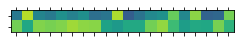

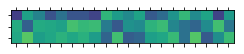

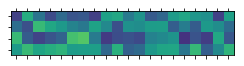

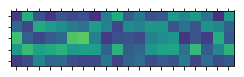

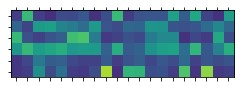

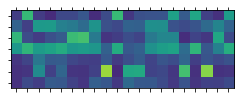

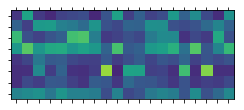

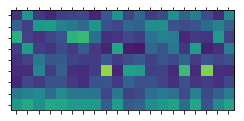

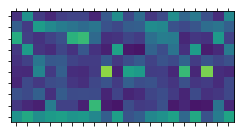

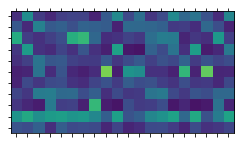

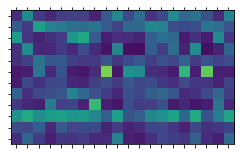

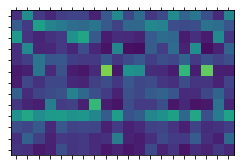

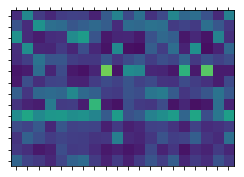

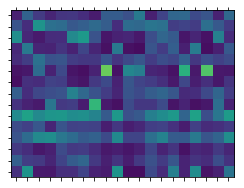

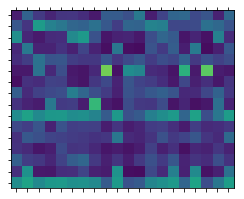

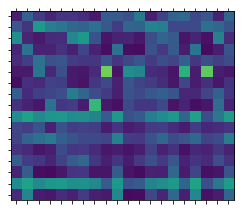

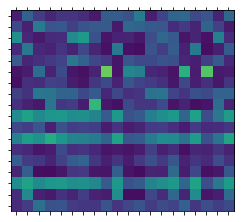

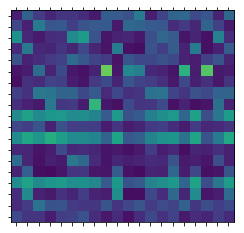

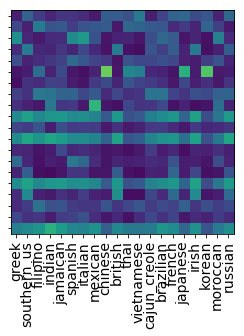

In [53]:
NComponentsMax = 20
corrmatList = []

for NComponents in np.arange(1,NComponentsMax)+1:

    # load in BMF results
    W = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_W.csv', header=None, index_col=False).values
    
    # calculate correlations between cuisines and latent recipes
    NCuisine = len(cuisineList)
    corrmatList.append(np.zeros((NComponents, NCuisine)))
    for iLatentRecipe in range(NComponents):
        for iCuisine in range(NCuisine):
            corrmatList[-1][iLatentRecipe, iCuisine] = np.corrcoef(cuisineIngredientFrequency.values[iCuisine,:],W[iLatentRecipe,:])[0,1]
    
    # plot the correlations
    fig, ax = plt.subplots(figsize=(4,NComponents/2))
    p = ax.matshow(corrmatList[-1], vmin=0, vmax=1)
    ax.set(xticks=range(NCuisine), yticks=range(NComponents), xticklabels=[], yticklabels=[])

ax.set_xticks(range(NCuisine))
ax.set_xticklabels(labels=cuisineList, rotation=90, fontsize=14)
ax.xaxis.tick_bottom()
plt.show()

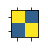

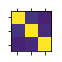

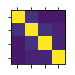

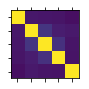

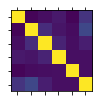

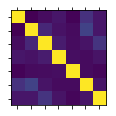

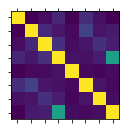

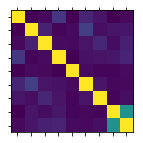

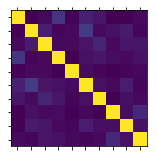

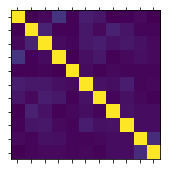

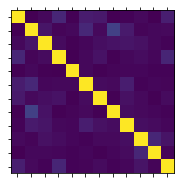

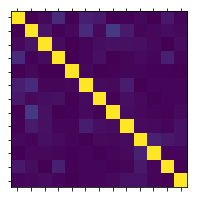

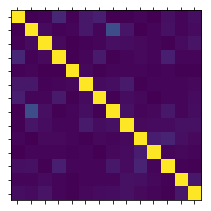

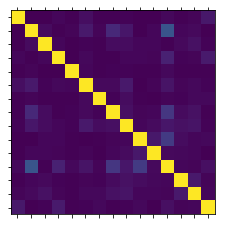

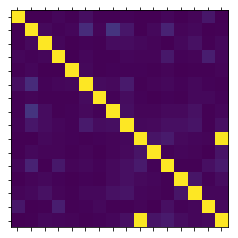

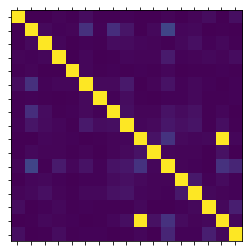

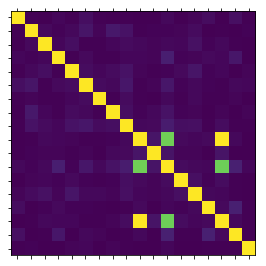

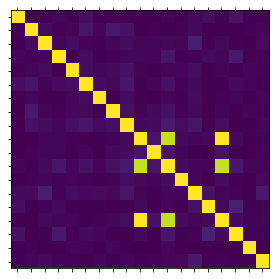

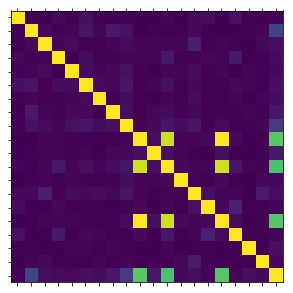

In [54]:
# similarity between latent recipes
NComponentsMax = 20
corrmatList = []

for NComponents in np.arange(1,NComponentsMax)+1:

    # load in BMF results
    W = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_W.csv', header=None, index_col=False).values
    
    # plot the correlations
    fig, ax = plt.subplots(figsize=(NComponents/4,NComponents/4))
    p = ax.matshow(np.corrcoef(W), vmin=0, vmax=1)
    ax.set(xticks=range(NComponents), yticks=range(NComponents), xticklabels=[], yticklabels=[])

plt.show()

### Mixture matrix H

#### Look at NComponents = 6 for an example

In [2]:
NComponents = 6
W = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_W.csv', header=None, index_col=False).values
H = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_H.csv', header=None, index_col=False).values

In [14]:
H.shape

(39774, 6)

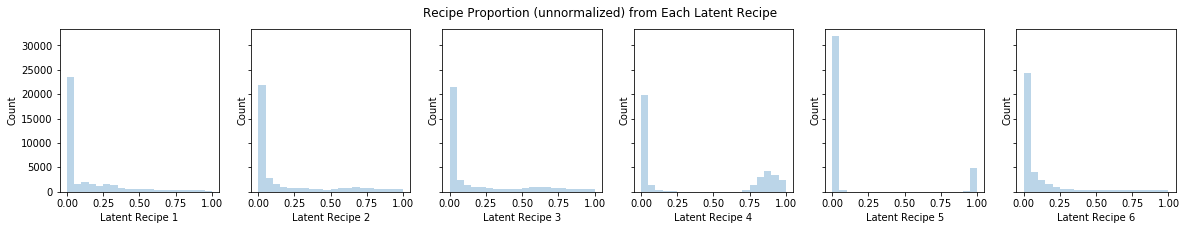

In [9]:
fig, axes = plt.subplots(1, NComponents, figsize=(20,3), sharey=True)
for i in range(NComponents):
    ax = axes[i]
    ax.hist(H[:, i], alpha=0.3, range=(0,1), bins=20)
    ax.set_xlabel('Latent Recipe '+str(i+1))
    ax.set_ylabel('Count')
fig.suptitle('Recipe Proportion (unnormalized) from Each Latent Recipe')
plt.show()

In [19]:
recipeSimilarity = np.corrcoef(H)

### ========== The end of main results ========== 

<a id='moreNComponent'></a>
### Supplementary: BMF with various number of "latent recipes"

You can change the criteria for selecting what ingredients to show for each latent recipe: now I'm showing only top 0.1% AND weight>0.1.

N component = 2


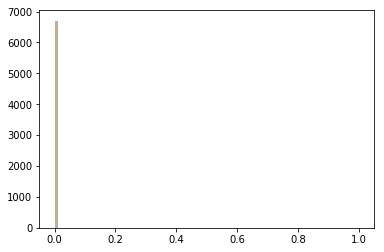

Top ingredients for each "latent recipe":
Latent recipe 1 : ['salt' 'sugar' 'all-purpose flour' 'butter' 'large eggs' 'eggs'
 'unsalted butter'] [0.08053401 0.07105847 0.06587143 0.04534633 0.03534655 0.02997743
 0.0299484 ]
Latent recipe 2 : ['salt' 'onions' 'olive oil' 'garlic' 'garlic cloves' 'water' 'pepper'] [0.04663837 0.03181066 0.02911801 0.02763563 0.02050929 0.01969326
 0.01695394]

N component = 3


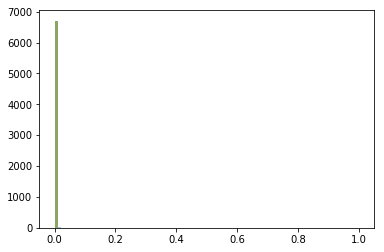

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'water' 'all-purpose flour' 'soy sauce' 'vegetable oil'
 'large eggs' 'unsalted butter'] [0.08152508 0.04542749 0.03254451 0.02863343 0.02278834 0.02171314
 0.01861884]
Latent recipe 2 : ['onions' 'olive oil' 'garlic' 'garlic cloves' 'water'
 'ground black pepper' 'tomatoes'] [0.04717799 0.0408669  0.03975541 0.0249375  0.01752798 0.01745979
 0.01325862]
Latent recipe 3 : ['salt' 'pepper' 'butter' 'all-purpose flour' 'eggs' 'black pepper'
 'ground black pepper'] [0.18580028 0.04075796 0.03018181 0.02164009 0.01491962 0.01336006
 0.01259521]

N component = 4


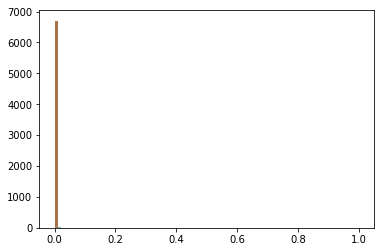

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'water' 'large eggs' 'soy sauce'
 'unsalted butter' 'baking powder'] [0.08530815 0.04474366 0.03625259 0.02660716 0.02301283 0.022427
 0.02140956]
Latent recipe 2 : ['onions' 'garlic' 'water' 'carrots' 'vegetable oil' 'tomatoes'
 'ground cumin'] [0.06922375 0.06519734 0.02168521 0.01592996 0.01463782 0.0134585
 0.01271876]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper'
 'extra-virgin olive oil' 'kosher salt' 'grated parmesan cheese'
 'fresh parsley'] [0.08719936 0.06507639 0.03449286 0.01522644 0.01497404 0.01341294
 0.01206551]
Latent recipe 4 : ['salt' 'pepper' 'butter' 'water' 'eggs' 'black pepper' 'milk'] [0.22699315 0.05591348 0.02530892 0.01835267 0.01762245 0.01439121
 0.01152694]

N component = 5


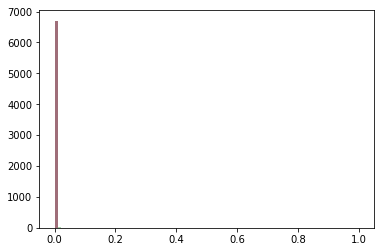

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter'
 'baking powder' 'butter' 'eggs'] [0.09797124 0.05935305 0.03405259 0.02904887 0.02629019 0.02348358
 0.02087816]
Latent recipe 2 : ['onions' 'garlic' 'carrots' 'vegetable oil' 'soy sauce' 'tomatoes'
 'ground cumin'] [0.0721575  0.07069793 0.01575457 0.01551235 0.01389716 0.01370033
 0.01329141]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'salt'
 'extra-virgin olive oil' 'kosher salt' 'grated parmesan cheese'] [0.09024544 0.06258808 0.03444308 0.0169055  0.01493147 0.01342175
 0.01264604]
Latent recipe 4 : ['salt' 'pepper' 'butter' 'eggs' 'oil' 'black pepper' 'milk'] [0.22834952 0.06126335 0.03013455 0.0197424  0.01276126 0.01250109
 0.01199479]
Latent recipe 5 : ['water' 'garlic cloves' 'soy sauce' 'vegetable oil' 'carrots'
 'corn starch' 'green onions'] [0.23154857 0.01813455 0.0152558  0.01457648 0.01398785 0.01324271
 0.01209419]

N compon

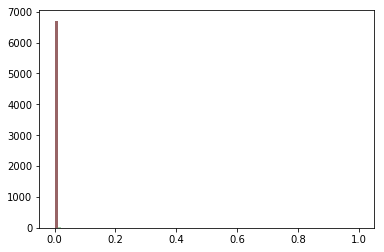

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter' 'butter'
 'baking powder' 'milk'] [0.0850695  0.08221686 0.04543397 0.04030344 0.03987605 0.03603109
 0.02749934]
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots'
 'vegetable oil'] [0.10280971 0.06391661 0.01911139 0.01787956 0.01515836 0.014578
 0.01285196]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'extra-virgin olive oil' 'grated parmesan cheese' 'purple onion'] [0.09750937 0.0621331  0.03440767 0.01444511 0.01435863 0.01262935
 0.01253364]
Latent recipe 4 : ['salt' 'pepper' 'butter' 'eggs' 'black pepper' 'oil' 'flour'] [0.2557784  0.06580773 0.02790924 0.02010412 0.01472816 0.01258871
 0.01221813]
Latent recipe 5 : ['water' 'garlic cloves' 'carrots' 'salt' 'vegetable oil' 'oil'
 'chopped onion'] [0.29996419 0.01535593 0.01193497 0.0112924  0.01100375 0.0102245
 0.00886349]
Latent recip

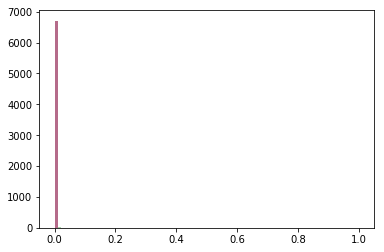

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'butter' 'unsalted butter'
 'baking powder' 'milk'] [0.08959247 0.08199799 0.04500103 0.04372876 0.04122415 0.03677618
 0.02871603]
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'carrots' 'chili powder'
 'diced tomatoes'] [0.11048598 0.06916169 0.02047397 0.01679522 0.01587301 0.0153971
 0.01069644]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'extra-virgin olive oil' 'grated parmesan cheese' 'purple onion'] [0.10272537 0.05920664 0.03342241 0.0145566  0.01345426 0.01297075
 0.01246311]
Latent recipe 4 : ['salt' 'pepper' 'butter' 'eggs' 'black pepper' 'oil' 'flour'] [0.27250858 0.06852576 0.02764912 0.01938508 0.01606934 0.0123917
 0.01234727]
Latent recipe 5 : ['water' 'garlic cloves' 'carrots' 'oil' 'salt' 'chopped onion'
 'corn starch'] [0.31773702 0.01407756 0.01272022 0.01037919 0.01005622 0.00845267
 0.00785723]
Latent recip

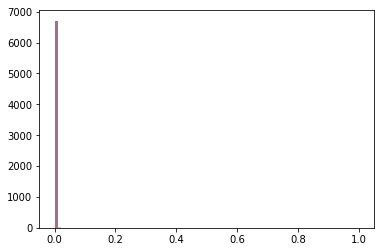

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter'
 'baking powder' 'vanilla extract' 'milk'] [0.12715388 0.07137542 0.05102286 0.04863881 0.03352854 0.02629393
 0.01950308]
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots'
 'diced tomatoes'] [0.10845717 0.07113735 0.02060414 0.01690269 0.01597978 0.01446988
 0.01060166]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'salt' 'kosher salt'
 'grated parmesan cheese' 'extra-virgin olive oil'] [0.10405193 0.05977071 0.03104824 0.0144034  0.01421695 0.01261673
 0.01261064]
Latent recipe 4 : ['salt' 'butter' 'eggs' 'all-purpose flour' 'milk' 'black pepper'
 'ground black pepper'] [0.19962478 0.05659067 0.02809421 0.02375829 0.01959007 0.01893119
 0.01269261]
Latent recipe 5 : ['water' 'salt' 'carrots' 'garlic cloves' 'oil' 'chopped onion'
 'corn starch'] [0.330348   0.01533425 0.01243219 0.01226254 0.0100418  0.0084

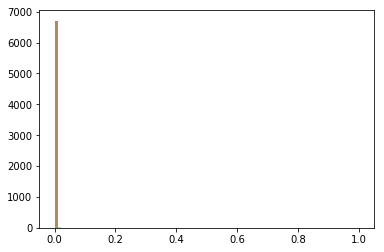

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'large eggs' 'unsalted butter'
 'baking powder' 'vanilla extract' 'baking soda'] [0.1529303  0.06388287 0.05133177 0.05052246 0.03247223 0.02392199
 0.01879103]
Latent recipe 2 : ['onions' 'garlic' 'tomatoes' 'ground cumin' 'chili powder' 'carrots'
 'diced tomatoes'] [0.10590541 0.07510316 0.02049894 0.01913069 0.01598574 0.0149724
 0.01062033]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'grated parmesan cheese' 'fresh parsley' 'fresh basil'] [0.11816138 0.06682458 0.02545911 0.0144842  0.01422522 0.01253685
 0.01209237]
Latent recipe 4 : ['butter' 'eggs' 'all-purpose flour' 'milk' 'baking powder' 'flour' 'salt'] [0.16800882 0.06402697 0.0504027  0.04860682 0.02069763 0.01929339
 0.01799398]
Latent recipe 5 : ['water' 'garlic cloves' 'carrots' 'oil' 'corn starch' 'chopped onion'
 'cinnamon sticks'] [0.33828081 0.01486802 0.01423312 0.01134813 0.00835206 0.007

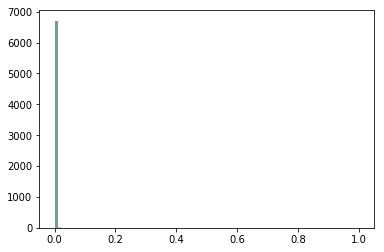

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda'] [0.16016061 0.05395467 0.04818874 0.04763236 0.02924733 0.02286785
 0.01744289]
Latent recipe 2 : ['onions' 'garlic' 'carrots' 'ground black pepper' 'tomatoes'
 'green bell pepper' 'celery'] [0.14727199 0.10254768 0.02249482 0.01673723 0.01542279 0.01296349
 0.01218772]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'grated parmesan cheese' 'fresh parsley' 'fresh basil'] [0.12501878 0.0691945  0.02932129 0.01643636 0.01462582 0.01281462
 0.01253242]
Latent recipe 4 : ['butter' 'eggs' 'all-purpose flour' 'milk' 'baking powder' 'white sugar'
 'flour'] [0.16310888 0.06064411 0.05551569 0.04825488 0.02219271 0.01737064
 0.01725976]
Latent recipe 5 : ['water' 'garlic cloves' 'carrots' 'oil' 'corn starch' 'chopped onion'
 'cinnamon sticks'] [0.33853324 0.01556573 0.01266706 0.01198254 0.0

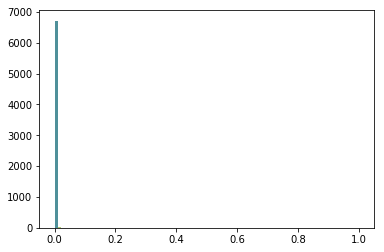

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda'] [0.17018968 0.04899534 0.04556804 0.04499597 0.02727651 0.0222875
 0.01647109]
Latent recipe 2 : ['garlic' 'ground black pepper' 'onions' 'kosher salt' 'ginger'
 'olive oil' 'celery'] [0.22745117 0.02764576 0.01725705 0.0164012  0.01445698 0.01195566
 0.01069105]
Latent recipe 3 : ['olive oil' 'garlic cloves' 'ground black pepper' 'kosher salt'
 'grated parmesan cheese' 'fresh parsley' 'dry white wine'] [0.13029436 0.06161466 0.02963408 0.0154716  0.01454637 0.01311861
 0.01276877]
Latent recipe 4 : ['butter' 'all-purpose flour' 'eggs' 'milk' 'baking powder'
 'vanilla extract' 'white sugar'] [0.16067288 0.06064125 0.05745051 0.04740065 0.02392466 0.01803623
 0.01689169]
Latent recipe 5 : ['water' 'carrots' 'oil' 'garlic cloves' 'corn starch' 'chopped onion'
 'bay leaves'] [0.34216232 0.01315542 0.0107346  0.00860819 0.

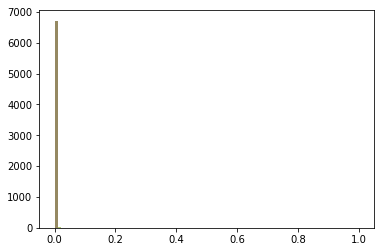

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda'] [0.17381057 0.04874663 0.04559471 0.04482349 0.02687823 0.02240665
 0.01649782]
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'ground black pepper' 'tomatoes' 'celery'
 'green bell pepper'] [0.14254265 0.12088353 0.01954442 0.01950342 0.01351662 0.01223433
 0.01147446]
Latent recipe 3 : ['olive oil' 'ground black pepper' 'grated parmesan cheese' 'kosher salt'
 'dried oregano' 'fresh parsley' 'dry white wine'] [0.17815567 0.03175382 0.01825321 0.01566681 0.01390016 0.01326596
 0.01275181]
Latent recipe 4 : ['butter' 'all-purpose flour' 'milk' 'grated parmesan cheese'
 'vanilla extract' 'baking powder' 'flour'] [0.21504542 0.05504815 0.03074937 0.01604639 0.01587264 0.01581028
 0.01167838]
Latent recipe 5 : ['water' 'carrots' 'oil' 'chopped onion' 'corn starch' 'cinnamon sticks'
 'ground turmeric'] [0.34664848 0.0126009

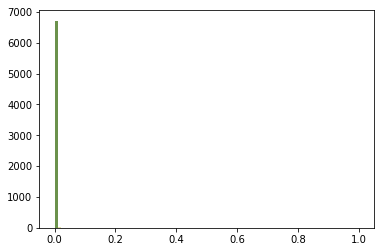

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda'] [0.16662876 0.05360621 0.04691207 0.04630027 0.0286318  0.02283857
 0.01724693]
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'ground black pepper' 'tomatoes' 'celery'
 'green bell pepper'] [0.13836483 0.12692506 0.02014849 0.01738417 0.01405722 0.01202323
 0.011756  ]
Latent recipe 3 : ['olive oil' 'ground black pepper' 'grated parmesan cheese' 'kosher salt'
 'dried oregano' 'fresh parsley' 'dry white wine'] [0.18845691 0.03526156 0.01947542 0.01702071 0.01358416 0.01344872
 0.01296506]
Latent recipe 4 : ['butter' 'all-purpose flour' 'milk' 'grated parmesan cheese'
 'baking powder' 'vanilla extract' 'flour'] [0.21560759 0.05773502 0.03277419 0.01720433 0.01694259 0.01636344
 0.011974  ]
Latent recipe 5 : ['water' 'oil' 'carrots' 'corn starch' 'chopped onion' 'cinnamon sticks'
 'ground turmeric'] [0.35514374 0.0133560

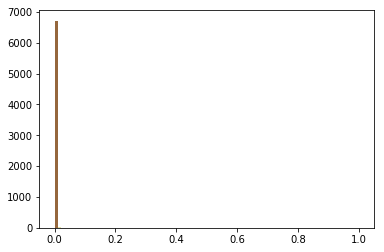

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'all-purpose flour' 'unsalted butter' 'large eggs'
 'baking powder' 'vanilla extract' 'baking soda'] [0.18235388 0.04439172 0.04267848 0.04150788 0.02581737 0.02328551
 0.01586633]
Latent recipe 2 : ['garlic' 'onions' 'ginger' 'carrots' 'tomatoes' 'celery' 'chicken broth'] [0.2171345  0.08261639 0.01527003 0.01259567 0.01118215 0.01065421
 0.0101483 ]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'fresh parsley' 'dry white wine'
 'dried oregano' 'fresh basil' 'red bell pepper'] [0.22480482 0.0198713  0.01359537 0.01326603 0.01310747 0.01253156
 0.01085159]
Latent recipe 4 : ['butter' 'all-purpose flour' 'milk' 'baking powder' 'vanilla extract'
 'grated parmesan cheese' 'ground cinnamon'] [0.21045527 0.06325572 0.03449498 0.01988817 0.01946209 0.01644108
 0.01114048]
Latent recipe 5 : ['water' 'oil' 'carrots' 'corn starch' 'chopped onion' 'cinnamon sticks'
 'ground turmeric'] [0.36217737 0.01233554 0.01216325

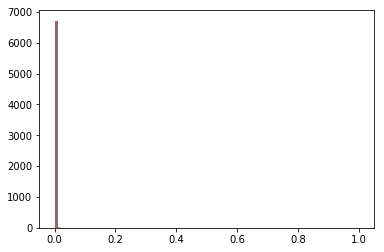

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'vanilla extract' 'large eggs' 'corn starch' 'kosher salt'
 'unsalted butter' 'fish sauce'] [0.26640586 0.01797999 0.01273312 0.01126082 0.00992892 0.00981912
 0.00970471]
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'tomatoes' 'ginger' 'celery' 'chicken broth'] [0.20637189 0.08556371 0.0149406  0.01458909 0.01448164 0.01101638
 0.01087498]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'dry white wine' 'fresh parsley'
 'dried oregano' 'fresh basil' 'red bell pepper'] [0.2388632  0.01973997 0.01354916 0.01350145 0.01283751 0.01207521
 0.01102987]
Latent recipe 4 : ['butter' 'milk' 'grated parmesan cheese' 'eggs' 'flour' 'vanilla extract'
 'fresh parsley'] [0.25327662 0.03400916 0.01904642 0.01854209 0.01577192 0.01531991
 0.01151428]
Latent recipe 5 : ['water' 'carrots' 'corn starch' 'chopped onion' 'cinnamon sticks'
 'bay leaves' 'tomato paste'] [0.38269874 0.01313492 0.00991082 0.00759979 0.00712214 0.005

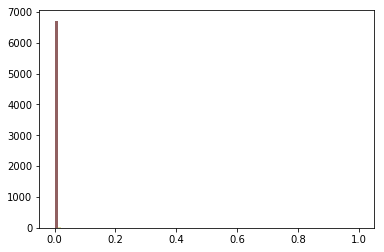

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'vanilla extract' 'corn starch' 'kosher salt' 'large egg yolks'
 'fish sauce' 'large eggs'] [0.27008925 0.01831112 0.0114891  0.01032458 0.00964614 0.00961438
 0.00917705]
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'tomatoes' 'green bell pepper' 'ginger'
 'celery'] [0.15044793 0.13843981 0.0205912  0.0160934  0.0134254  0.01292883
 0.01269443]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'fresh parsley' 'dry white wine'
 'dried oregano' 'fresh basil' 'red bell pepper'] [0.24048122 0.02049014 0.01385947 0.01383378 0.01319621 0.01257815
 0.01095419]
Latent recipe 4 : ['butter' 'milk' 'grated parmesan cheese' 'flour' 'vanilla extract'
 'all-purpose flour' 'fresh parsley'] [0.25973167 0.03462627 0.01936635 0.01645826 0.01575185 0.01425453
 0.01167008]
Latent recipe 5 : ['water' 'carrots' 'oil' 'corn starch' 'cinnamon sticks' 'potatoes'
 'cumin seed'] [0.37539504 0.01246652 0.01096267 0.00952643 0.00753676 0

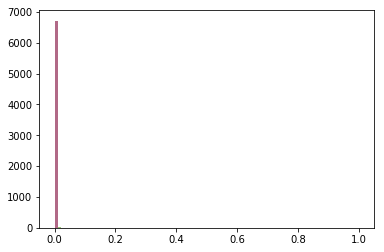

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'vanilla extract' 'baking powder' 'corn starch' 'kosher salt'
 'fish sauce' 'large egg yolks'] [0.27805536 0.0182936  0.01327535 0.01190765 0.01024609 0.00998835
 0.00961988]
Latent recipe 2 : ['garlic' 'onions' 'carrots' 'tomatoes' 'green bell pepper' 'celery'
 'ginger'] [0.15338024 0.13607899 0.02111937 0.01756635 0.01413946 0.01322473
 0.01279706]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'dry white wine' 'fresh parsley'
 'dried oregano' 'fresh basil' 'red bell pepper'] [0.24430163 0.02028997 0.01391733 0.01383501 0.01297349 0.01255351
 0.01093782]
Latent recipe 4 : ['butter' 'milk' 'grated parmesan cheese' 'vanilla extract' 'flour'
 'fresh parsley' 'heavy cream'] [0.26927718 0.03283831 0.01934487 0.01577199 0.0150308  0.01207541
 0.01162025]
Latent recipe 5 : ['water' 'carrots' 'corn starch' 'cinnamon sticks' 'chopped onion'
 'bay leaves' 'fish sauce'] [0.3919173  0.01256336 0.01005724 0.00716606 0.0

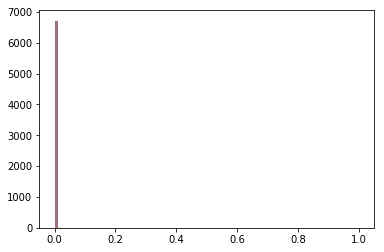

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'vanilla extract' 'corn starch' 'baking powder' 'kosher salt'
 'fish sauce' 'large egg yolks'] [0.27273983 0.01802207 0.01211363 0.01206986 0.01033623 0.00993022
 0.00950046]
Latent recipe 2 : ['garlic' 'ginger' 'onions' 'yellow onion' 'fish sauce' 'kosher salt'
 'cilantro'] [0.26284628 0.01789662 0.01239139 0.01220208 0.0106718  0.00922932
 0.008528  ]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'fresh parsley' 'dry white wine'
 'dried oregano' 'fresh basil' 'red bell pepper'] [0.24478634 0.02154804 0.01491296 0.01427658 0.01379972 0.01288175
 0.0115279 ]
Latent recipe 4 : ['butter' 'milk' 'eggs' 'flour' 'grated parmesan cheese' 'vanilla extract'
 'fresh parsley'] [0.25062681 0.03996626 0.03069504 0.0196568  0.01954139 0.01503914
 0.0116305 ]
Latent recipe 5 : ['garlic cloves' 'extra-virgin olive oil' 'cooking spray'
 'fresh lemon juice' 'chopped onion' 'crushed red pepper' 'fresh basil'] [0.22122034 0.02

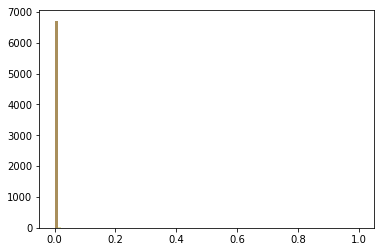

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'vanilla extract' 'corn starch' 'baking powder' 'fish sauce'
 'large egg yolks' 'kosher salt'] [0.27064364 0.01781293 0.01214658 0.01203927 0.00987645 0.00945633
 0.00882718]
Latent recipe 2 : ['garlic' 'ginger' 'onions' 'yellow onion' 'fish sauce' 'kosher salt'
 'cilantro'] [0.26666973 0.01813066 0.01390615 0.01251795 0.01088068 0.00892478
 0.00875877]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'dry white wine' 'dried oregano'
 'fresh parsley' 'fresh basil' 'red bell pepper'] [0.23327243 0.02023534 0.01445401 0.01430194 0.01426728 0.01313014
 0.01204306]
Latent recipe 4 : ['butter' 'milk' 'eggs' 'flour' 'grated parmesan cheese' 'vanilla extract'
 'heavy cream'] [0.24384183 0.04098263 0.03494226 0.02117237 0.01889225 0.01483228
 0.01137991]
Latent recipe 5 : ['garlic cloves' 'cooking spray' 'chopped onion' 'crushed red pepper'
 'chopped cilantro fresh' 'fresh lime juice' 'peeled fresh ginger'] [0.26366581

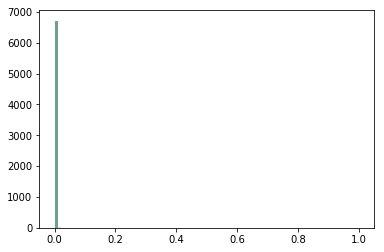

Top ingredients for each "latent recipe":
Latent recipe 1 : ['sugar' 'vanilla extract' 'baking powder' 'corn starch' 'fish sauce'
 'large egg yolks' 'unsalted butter'] [0.26903438 0.01788699 0.01219424 0.01207251 0.00981213 0.00947605
 0.00906029]
Latent recipe 2 : ['garlic' 'ginger' 'onions' 'yellow onion' 'fish sauce' 'kosher salt'
 'diced tomatoes'] [0.27476368 0.01877626 0.01459934 0.0128438  0.01132873 0.00966522
 0.0086798 ]
Latent recipe 3 : ['olive oil' 'grated parmesan cheese' 'dry white wine' 'fresh parsley'
 'dried oregano' 'fresh basil' 'red bell pepper'] [0.23639285 0.02050344 0.01459174 0.01446203 0.01433025 0.01330317
 0.01211896]
Latent recipe 4 : ['butter' 'milk' 'eggs' 'flour' 'grated parmesan cheese' 'vanilla extract'
 'heavy cream'] [0.23799019 0.04259402 0.0397179  0.02150809 0.01864259 0.01510457
 0.01123741]
Latent recipe 5 : ['garlic cloves' 'cooking spray' 'chopped onion' 'crushed red pepper'
 'chopped cilantro fresh' 'fresh lime juice' 'peeled fresh ginger'] [

In [27]:
for NComponents in np.arange(1,20)+1:

    print('N component =', NComponents)

    # load in BMF results
    W = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_W.csv', header=None, index_col=False).values
    W = W/np.sum(W,axis=1)[:,np.newaxis]
#     H = pd.read_csv('BMFresults/NComponents'+str(NComponents)+'_H.csv', header=None, index_col=False).values

    # histogram of feature weights for each "latent recipe"
    for i in range(NComponents):
        sns.distplot(W[i,:], bins=np.linspace(0,1,101), label=i, kde=False)
    plt.show()

    # top ingredients for each "latent recipe"
    print('Top ingredients for each "latent recipe":')
    for i in range(NComponents):
        topIndices = np.where((W[i,:] > np.percentile(W[i,:], 99.9)))[0] #&(W[i,:] > 0.1)
        topIndices = topIndices[np.argsort(-W[i, topIndices])]
        print('Latent recipe', i+1, ':', dataBinaryIngredients.columns.values[topIndices], W[i, topIndices]) #, W[i, topIndices]
    
    print('')